# Credit Card Approval mit Machine Learning
WWI20DSA; Semester-4;  <br>
Chengyi Hua (8883221); Yassir Knierim (7362794); Jan Rüdt (1737304)

## Projektbeschreibung
Das Kredit-Scoring ist eine weit verbreitete Methode des Risikomanagements im Finanzsektor. Es verwendet persönliche Informationen und Daten, die von Kreditkartenantragstellern bereitgestellt werden, um zukünftige Insolvenzen und Kreditkartendarlehen abzuschätzen. Die Bank ist befugt zu entscheiden, ob sie dem Antragsteller eine Kreditkarte zur Verfügung stellt oder nicht. Kredit-Scores können das Risikoniveau objektiv einschätzen. Ein maschinelles Lernmodell ist erforderlich, um vorherzusagen, ob eine Anwendung in diesem Datensatz ein „guter“ oder „schlechter“ Benutzer ist. Durch unsere Zielvariable oder Definition soll sie vorhersagen, ob der Benutzer als Risikobenutzer eingestuft wird oder nicht.
<br>
<br>

## Ziel:
![](confusionM.png) <br>
In diesem Projekt werden risikobehaftete Kunden als 1 und risikofreie als 0 definiert. Dabei wird es wichtig sein den Fehler Typ II soweit wie möglich zu vermeiden. In diesem Fall bedeutet Fehler Type II, dass Kunden eine credit card approval bekommen würden, obwohl sie als risikobehaftet erkannt werden sollte.
<br><br>

theorie: Confusions Matrix und Fehler Type I und II <br>
 
Hürden: <br>
-  Das Problem der unausgeglichenen Daten ist ein wesentliches Problem in diesem Projekt.<br>
Mögliche Lösung: Verwenden Sie das Paket PyCaret, um den unausgeglichenen Datensatz zu reparieren
-  Experimente mit verschiedene Modelle. Schnelleres Vorgehen mit __PyCaret__ möglich
-  Down- oder Oversampling

### Definition der Parameter
| Attribut Bezeichnung | Beschreibung | Kommentar |
| ------------ | ----------- | ------- |
|applicant_ID| Kundennummer |Für das Modell nicht relevant |	
|gender|	Geschlecht|Kategorial	|
|owning_car|	Autobesitz	|Kategorial |
|owning_property|	Immobilienbesitz	|Kategorial |
|children_amt|	Anzahl von Kindern|Numerisch |	
|anual_income|	Jährliches Einkommen|Numerisch |	
|education_level|	Bildungsniveau	|Kategorial |
|marital_status|	Familienstand	|Kategorial |
|housing_type|	Wohnsituation	|Kategorial |
|age|Alter |Numerisch |
|working_years|	Arbeitsdauer in Jahren|Numerisch |	
|owning_phone|	Handybesitz	|Kategorial |
|owning_work_phone|	Arbeitshandybesitz	|Kategorial |
|owning_email|	Emailbesitz	|Kategorial |
|job|Arbeitstitel|Kategorial |
|payment_status|	Status|1: 1–29 Tage überfällig<br> 2: 30–59 Tage überfällig<br> 3: 60–89 Tage überfällig<br> 4: 90–119 Tage überfällig<br> 5: 120–149 Tage überfällig<br> 6: Überfällig oder uneinbringlich, Abschreibungen für mehr als 150 Tage<br> -1: in diesem Monat abbezahlt<br> 0: kein Darlehen für den Monat. Kategorial|
|risk_user|	Ziel|	Risikonutzer sind mit „1“ gekennzeichnet, ansonsten mit „0“. Kategorial|

Tabelle (1)<br>
@Dennis Knierim

In [1]:
categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level','marital_status', 'housing_type', 'job']


## Loading dependencies

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as mso
import warnings
import pycaret
import math
from collections import Counter
from numpy.random import default_rng
from imblearn.under_sampling import *
import imblearn
from sklearn.model_selection import KFold
from pycaret.classification import *

# --- Libraries Settings ---
#warnings.filterwarnings('ignore')
#plt.rcParams['figure.dpi'] = 100

## Datenanpassung

In [3]:
cca =  pd.read_csv('credit_card_approval.csv')
# rough years of employment
cca.DAYS_EMPLOYED = abs(cca.DAYS_EMPLOYED) // 365
# finding out each customers age
cca.DAYS_BIRTH =  abs(cca.DAYS_BIRTH) // 365  
cca.AMT_INCOME_TOTAL = pd.to_numeric(cca.AMT_INCOME_TOTAL)
# dropping unneccessary attributes
cca = cca.drop("FLAG_MOBIL", axis=1)



cca.rename(columns = {'CODE_GENDER':'gender', 
                      'DAYS_BIRTH': 'age',
                      'DAYS_EMPLOYED': 'working_years',
                      'FLAG_OWN_CAR':'owning_car',
                      'FLAG_OWN_REALTY': 'owning_property',
                      'CNT_CHILDREN': 'children_amt',
                      'AMT_INCOME_TOTAL': 'anual_income',
                      'NAME_EDUCATION_TYPE': 'education_level',
                      'NAME_FAMILY_STATUS': 'marital_status',
                      'NAME_HOUSING_TYPE': 'housing_type',
                      'FLAG_WORK_PHONE': 'owning_work_phone',
                      'FLAG_EMAIL': 'owning_email',
                      'FLAG_PHONE': 'owning_phone',
                      'STATUS': 'payment_status',
                      'TARGET': 'risk_user',
                      'JOB': 'job',
                      'ID': 'applicant_ID'
                      }, inplace = True)


cca["owning_car"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["owning_property"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["payment_status"].replace({'0' : '1', 
                               '1': '2', 
                               '2': '3', 
                               '3': '4', 
                               '4': '5', 
                               '5': '6', 
                               'C': '-1', 
                               'X': '0'}, inplace= True)
cca.payment_status = [int(i) for i in cca.payment_status ]
cca = cca.sort_values('applicant_ID')



In [4]:
cca.dtypes

applicant_ID           int64
gender                object
owning_car            object
owning_property       object
children_amt          object
anual_income         float64
education_level       object
marital_status        object
housing_type          object
age                    int64
working_years          int64
owning_work_phone      int64
owning_phone           int64
owning_email           int64
job                   object
BEGIN_MONTHS           int64
payment_status         int64
risk_user             object
dtype: object

In [5]:
def get_count_of(applicant_frame,column,credit_type):
    df = applicant_frame
    df[column].replace({0:'no_credit',
        -1:'good',
        1:'good',
        2:'bad',
        3:'bad',
        4:'bad',
        5:'bad',
        6:'bad'}, inplace=True)
    values = df[column].value_counts()
    try:
        return values[values.index==credit_type][0]
    except:
        return 0

get_count_of(cca[cca.applicant_ID==5008806],'payment_status','good')

14

In [6]:
good_mapping = {i:get_count_of(cca[cca.applicant_ID==i],'payment_status','good') for i in list(cca.applicant_ID.unique())}
bad_mapping = {i:get_count_of(cca[cca.applicant_ID==i],'payment_status','bad') for i in list(cca.applicant_ID.unique())}
no_mapping = {i:get_count_of(cca[cca.applicant_ID==i],'payment_status','no_credit') for i in list(cca.applicant_ID.unique())}

In [7]:
bad_mapping

{5008806: 0,
 5008808: 0,
 5008809: 0,
 5008810: 0,
 5008811: 0,
 5008815: 0,
 5008819: 0,
 5008820: 0,
 5008821: 0,
 5008822: 0,
 5008823: 0,
 5008824: 0,
 5008825: 1,
 5008826: 7,
 5008830: 2,
 5008831: 2,
 5008832: 2,
 5008836: 0,
 5008837: 0,
 5008838: 0,
 5008839: 0,
 5008840: 0,
 5008841: 0,
 5008842: 0,
 5008843: 0,
 5008844: 0,
 5008846: 0,
 5008847: 0,
 5008849: 0,
 5008850: 0,
 5008851: 0,
 5008852: 0,
 5008853: 0,
 5008854: 0,
 5008855: 0,
 5008856: 0,
 5008857: 0,
 5008858: 0,
 5008859: 0,
 5008860: 0,
 5008861: 0,
 5008862: 0,
 5008863: 0,
 5008864: 0,
 5008865: 0,
 5008866: 0,
 5008867: 0,
 5008868: 0,
 5008870: 0,
 5008872: 1,
 5008873: 0,
 5008874: 0,
 5008875: 0,
 5008876: 0,
 5008877: 0,
 5008878: 3,
 5008879: 0,
 5008880: 0,
 5008881: 0,
 5008882: 0,
 5008888: 0,
 5008889: 0,
 5008890: 0,
 5008891: 0,
 5008892: 0,
 5008893: 0,
 5008894: 0,
 5008895: 0,
 5008896: 0,
 5008897: 0,
 5008898: 0,
 5008899: 0,
 5008900: 0,
 5008901: 0,
 5008902: 1,
 5008903: 0,
 5008904: 1,

In [8]:
cca['total_good_credit'] = cca.applicant_ID.map(good_mapping)
cca['total_bad_credit'] = cca.applicant_ID.map(bad_mapping)
cca['total_no_credit'] = cca.applicant_ID.map(no_mapping)

In [9]:
cca_t0 = cca[cca.BEGIN_MONTHS==0]

In [10]:
# checking for datatype of the different attributes
#print(cca.dtypes)

# getting insides into the attribute contents, Check for na and errors
#columns = []
#for n in cca.columns:
#    columns.append(n)

#for n in columns:  
#    print(n)
#    print(cca[n].unique())
#    for i in cca[n].isna():
#        if i == True:
#            print("AHAAAA")
#    print('\n \n')   
#print(cca.isnull().sum())


In [11]:
cca_unique_id = cca.drop_duplicates('applicant_ID')
cca_unique_id.sample(10)

applicant_ID gender owning_car owning_property children_amt  \
519231       5096317      M          1               0  No children   
454489       5045637      M          1               1   1 children   
487492       5096381      F          1               0  2+ children   
7395         5054584      F          0               1  No children   
185939       5042018      M          1               0  No children   
59341        5146284      F          0               1  No children   
450727       5068535      M          0               0  No children   
367451       5095559      F          0               0  No children   
319350       5091956      F          0               1  No children   
170532       5100307      M          1               1  2+ children   

        anual_income                education_level        marital_status  \
519231      270000.0               Higher education  Single / not married   
454489      139500.0  Secondary / secondary special               Married   
487492      243000.0  Secondary / secondary special               Married   
7395        382500.0  Secondary / secondary special                 Widow   
185939      180000.0  Secondary / secondary special               Married   
59341       180000.0  Secondary / secondary special        Civil marriage   
450727      157500.0  Secondary / secondary special               Married   
367451       90000.0  Secondary / secondary special               Married   
319350      135000.0  Secondary / secondary special               Married   
170532      405000.0  Secondary / secondary special               Married   

             housing_type  age  working_years  owning_work_phone  \
519231  House / apartment   26              0                  0   
454489  House / apartment   39             15                  1   
487492  House / apartment   32              4                  0   
7395    House / apartment   50             14                  1   
185939  House / apartment   28              0                  0   
59341   House / apartment   44             20                  1   
450727  House / apartment   57              5                  0   
367451  House / apartment   44              1                  1   
319350  House / apartment   42              1                  0   
170532  House / apartment   29              9                  0   

        owning_phone  owning_email                    job  BEGIN_MONTHS  \
519231             0             0             Core staff             0   
454489             0             0               Laborers             0   
487492             0             0         Medicine staff             0   
7395               0             0  Private service staff             0   
185939             1             0                Drivers             0   
59341              0             0             Core staff             0   
450727             0             0               Laborers             0   
367451             0             0               Laborers             0   
319350             0             0               Laborers             0   
170532             0             0               Managers             0   

        payment_status risk_user  total_good_credit  total_bad_credit  \
519231              -1         N                 15                 0   
454489               1         N                  3                 0   
487492              -1         N                 11                 0   
7395                 1         N                  8                 5   
185939              -1         N                 12                 2   
59341                0         N                  0                 0   
450727               1         N                  3                 0   
367451              -1         N                 57                 1   
319350              -1         N                 13                 0   
170532              -1         N                 34                 0   


## Testdatensatz von 20%
Es wir einen zufälligen Test-Datensatz von 20 Prozent gesampelt. 

---- Theorie.

In [57]:
cca_for_test = cca_unique_id.drop(['BEGIN_MONTHS','payment_status'], axis= 1)
training_data = cca_for_test.sample(frac=0.8, random_state=25)
testing_data = cca_for_test.drop(training_data.index)

## Deskriptive Analyse / Visualisierung 

Die deskriptive Analyse, auch bekannt als deskriptive Analytik oder deskriptive Statistik, ist der Prozess der Verwendung statistischer Techniken zur Beschreibung oder Zusammenfassung einer Reihe von Daten. Als eine der wichtigsten Arten der Datenanalyse ist die deskriptive Analyse beliebt, da sie zugängliche Erkenntnisse aus Daten generieren kann. [1]

Im Gegensatz zu anderen Arten der Datenanalyse versucht die deskriptive Analyse nicht, Vorhersagen über die Zukunft zu treffen. Stattdessen zieht es Erkenntnisse ausschließlich aus vergangenen Daten, indem es sie auf eine Weise manipuliert, die sie aussagekräftiger macht.

@Chengyi Hua

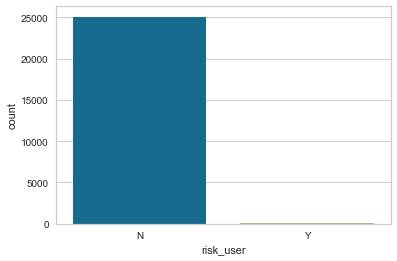

In [12]:
cca_unique_id[cca_unique_id.risk_user=='N'].count()[0]

In [13]:
#riskuser_plot = sns.countplot(x='risk_user',data=cca_unique_id)
fig = go.Figure([go.Bar(x=['N','Y'], 
y=[cca_unique_id[cca_unique_id.risk_user=='N'].count()[0], cca_unique_id[cca_unique_id.risk_user=='Y'].count()[0]])])
fig


In [14]:
def class_count(y):
    counter = Counter(y)
    for k, v in counter.items():
        dist = v / len(y) * 100
        print(f"Class={k}, n={v} ({dist}%)")

class_count(cca_unique_id.risk_user)

Class=N, n=25062 (99.71353544998807%)
Class=Y, n=72 (0.28646455001193605%)


Unser Datensatz weist weniger als 1% seltener, aber “interessanter” Ereignisse auf (z. B. User, die als ...). Es ist also ein unausgewogener Datensatz. Die meisten Algorithmen zum maschinellen Lernen funktionieren jedoch nicht gut mit unausgewogenen Datensätzen. 

#### Problem mit unausgeglichenem Datensatz <br>
Auswirkung / Folgen: <br>
- __Eine unausgewogene Klassifizierung__. Es für zu der Entwicklung von Vorhersagemodellen für Klassifizierungsdatensätze, die ein schwerwiegendes Klassenungleichgewicht aufweisen. Die Herausforderung bei der Arbeit mit unausgewogenen Datensätzen besteht darin, dass die meisten maschinellen Lerntechniken die Minderheitsklasse ignorieren und dafür eine schlechte Leistung erbringen, obwohl normalerweise die Leistung der Minderheitsklasse am wichtigsten ist.<br><br>




In [15]:
#extracting applicants not being risk user
non_risk_user = cca_unique_id[cca_unique_id.risk_user == 'N']
#not_risk.sample(10)

#extracting applicants being risk user
risk_user = cca_unique_id[cca_unique_id.risk_user == 'Y']
#risk.sample(10)

In [16]:
fig = go.Figure([go.Bar(x=['F','M'], 
y=[cca_unique_id[cca_unique_id.gender=='F'].count()[0], cca_unique_id[cca_unique_id.gender=='M'].count()[0]])])
fig



- fig(1): Verteilung von Männern und Frauen in der Tabelle cca_unique_id. In der Tabelle sind viel mehr Frauen als Männer aufgelistet.

In [206]:
class_count(cca_unique_id.gender)

Class=M, n=6518 (38.24444053277005%)
Class=F, n=10525 (61.75555946722995%)


In [208]:
fig = go.Figure([go.Bar(x=['F','M'], 
y=[risk_user[risk_user.gender=='F'].count()[0], risk_user[risk_user.gender=='M'].count()[0]])])
fig


- fig(2): Verteilung von Männern und Frauen, die als "Risk User" gekennzeichnet wurden. Männliche Risk User sind etwas häufiger als weibliche Risk User in dieser Tabelle.

In [209]:
class_count(risk_user.gender)

Class=M, n=32 (50.79365079365079%)
Class=F, n=31 (49.2063492063492%)


In [211]:
fig = go.Figure([go.Bar(x=['F','M'], 
y=[non_risk_user[non_risk_user.gender=='F'].count()[0], non_risk_user[non_risk_user.gender=='M'].count()[0]])])
fig


- fig(3): Verteilung von Männern und Frauen, die als Non-Risk User gekennzeichnet wurden. Man sieht dass es deutlich mehr weibliche Non-Risk User gibt als männliche. 
- Ein männlicher User hat eine höhere Wahrscheinlichkeit in dieser Tabelle als Risk-User gekennzeichnet zu sein.

In [212]:
class_count(non_risk_user.gender)

Class=M, n=6486 (38.197879858657245%)
Class=F, n=10494 (61.802120141342755%)


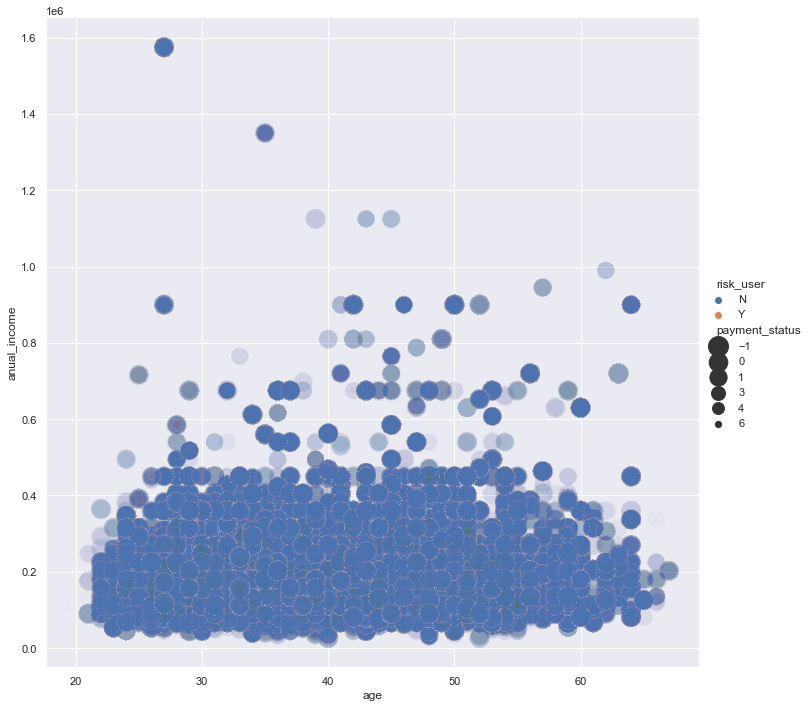

In [199]:
plot_1 = sns.relplot(x='age', y='anual_income', hue='risk_user',size='payment_status',data=cca,sizes=(400,40),alpha=0.01,height=10)

- fig(4): In dieser Visualisierung versuchen wir eine klare Abtrennung von Risk- und Non-Risk-Unsern darzustellen. Wir plotten dazu die Parameter 'age', 'annual income'  und 'payment status' bei Risk und Non-Risk user. Allerdigns kann keine klare Abtrennung im Scatter-Plot beobachtet werden. Zu sehen ist lediglich, dass die blauen Punkte, die Non-Risk-User darstellen, kleiner sind als die gelben Punkte, die Risk-User darstellen. Man schließt daraus, dass sich lediglich der Parameter 'payment_status' in den beiden Kategorien klar unterscheidet.

@Dennis

In [214]:
y_list=[]
for i in list(risk_user.payment_status.unique()):
    y_list.append(risk_user[risk_user.payment_status==i].count()[0])

fig = go.Figure([go.Bar(x=list(risk_user.payment_status.unique()), 
y=y_list)])
fig


- fig(5): dieser Plot zeigt den 'payment status' aller Risk-User. Es zeichnet sich heraus, dass die meisten Personen in dieser Gruppe einen Zahlungsstatus von 6 haben, also mit ihren Rückzahlungen stark im Verzug sind (siehe Tabelle 1) 

In [215]:
class_count(risk_user.payment_status)

Class=4, n=3 (4.761904761904762%)
Class=6, n=44 (69.84126984126983%)
Class=3, n=12 (19.047619047619047%)
Class=5, n=4 (6.349206349206349%)


In [217]:
y_list=[]
for i in list(non_risk_user.payment_status.unique()):
    y_list.append(non_risk_user[non_risk_user.payment_status==i].count()[0])

fig = go.Figure([go.Bar(x=list(non_risk_user.payment_status.unique()), 
y=y_list)])
fig


- fig(6): Dieser Plot zeigt den Zahlungsstatus aller Non-Risk-User. Sie sind mit ihren Rückzahlungen Pünktlich oder nur leicht im Verzug, was einen starken Kontrast zu den Risk-Usern darstellt.

In [218]:
class_count(non_risk_user.payment_status)

Class=-1, n=8890 (52.35571260306242%)
Class=1, n=4783 (28.16843345111896%)
Class=0, n=3138 (18.480565371024735%)
Class=2, n=169 (0.9952885747938751%)


In [219]:
y_list=[]
for i in list(risk_user.housing_type.unique()):
    y_list.append(risk_user[risk_user.housing_type==i].count()[0])

fig = go.Figure([go.Bar(x=list(risk_user.housing_type.unique()), 
y=y_list)])
fig


In [220]:
y_list=[]
for i in list(non_risk_user.housing_type.unique()):
    y_list.append(non_risk_user[non_risk_user.housing_type==i].count()[0])

fig = go.Figure([go.Bar(x=list(non_risk_user.housing_type.unique()), 
y=y_list)])
fig




Mögliche Lösung für unbalanced Dataset: <br>
- __over sampling__: Ein Ansatz zur Behandlung unausgewogener Datensätze besteht darin, die Minderheitsklasse zu "oversample". Der einfachste Ansatz besteht darin, Beispiele in der Minderheitsklasse zu duplizieren, diese Beispiele gibt dem Modell keine neuen Informationen. Es werden neue Beispiele aus den bestehenden Beispielen synthetisiert. Dies ist eine Art Datenvermehrung für die Minderheitsschicht und wird als Synthetic Minority Oversampling Technique, kurz SMOTE, bezeichnet. <br> <br>
Diese Möglichkeit ist in der PyCarat Bikliothek integriert. Mit __fix_imbalance is True__
, wird der unausgewogene Datensatz angepasst. Auf __Default__ ist der __fit_resample__ Methode auf SMOTE festgelegt.<br> <br>

- __under ampling__: Under-Sampling gleicht den Datensatz aus, indem die Größe der reichlich vorhandenen Klasse reduziert wird. Diese Methode wird verwendet, wenn die Datenmenge ausreicht. Indem alle Stichproben in der seltenen Klasse gehalten werden und zufällig eine gleiche Anzahl von Stichproben in der reichlich vorhandenen Klasse ausgewählt wird, kann ein ausgewogener neuer Datensatz zur weiteren Modellierung abgerufen werden<br><br>
@Chengyi Hua<br> 

## Versuche mit PyCarat <br>

### Gründe für die Benutzung von PyCaret, ein Open-scource ML Bibliothek.

PyCaret ist eine Open-Source-Low-Code-Bibliothek für maschinelles Lernen in Python, die Arbeitsabläufe für maschinelles Lernen automatisiert. Es ist ein End-to-End-Tool für maschinelles Lernen und Modellmanagement, das den Experimentzyklus exponentiell beschleunigt und sie produktiver macht.
<br>
<br>
Verglichen mit den anderen Open-Source-Bibliotheken für maschinelles Lernen ist PyCaret eine alternative Low-Code-Bibliothek, mit der Hunderte von Codezeilen durch nur wenige Zeilen ersetzt werden können. Dies macht Experimente exponentiell schnell und effizient. PyCaret ist im Wesentlichen ein Python-Wrapper um mehrere Bibliotheken und Frameworks für maschinelles Lernen wie scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray und einige mehr.
<br>
<br>
Da immer mehr Unternehmen ihren Fokus auf maschinelles Lernen verlagern, um schwierige Probleme anzugehen, werden von Datenwissenschaftlern erwartet, dass sie schneller Ergebnisse liefern können. Dies hat die Nachfrage nach der Automatisierung wichtiger Phasen in Data-Science-Projekten erhöht, sodass sich Data Scientists auf das eigentliche Problem konzentrieren können, anstatt Hunderte von Codezeilen zu schreiben, um das optimale Modell zu identifizieren.

@Chengyi Hua

theorie tratifiedkfold und kfold unterscheid und verwendung.  im Bezug auf Pycarat

theorie: Cross validierung, weil es hier verwendet wird

In [29]:
cca_for_test = cca_unique_id.drop(['BEGIN_MONTHS','payment_status'], axis= 1)
training_data = cca_for_test.sample(frac=0.8, random_state=25)
testing_data = cca_for_test.drop(training_data.index)


## Oversampling mit Pycaret

theorie: SMOTE

In [30]:

stp = pycaret.classification.setup(data = training_data, target = 'risk_user', train_size = 0.8,
            categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level',
                                    'marital_status', 'housing_type', 
                                    'job'], fold_strategy = 'kfold',
            fix_imbalance = True, fix_imbalance_method = imblearn.over_sampling.SMOTE(), fold = 10,
            ignore_features = ['applicant_ID'],
            use_gpu=True)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
0,Session id,2215
1,Target,risk_user
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(20107, 18)"
5,Transformed data shape,"(36094, 28)"
6,Transformed train set shape,"(32072, 28)"
7,Transformed test set shape,"(4022, 28)"
8,Ignore features,1


In [13]:
best_model_with_oversampling = compare_models(exclude= 'dummy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9969,0.9373,0.0000,0.0000,0.0000,-0.0001,-0.0001,2.6240
et,Extra Trees Classifier,0.9966,0.9256,0.1167,0.1400,0.1167,0.1160,0.1215,2.0740
dt,Decision Tree Classifier,0.9901,0.6129,0.2333,0.1195,0.1019,0.1003,0.1284,1.0910
knn,K Neighbors Classifier,0.9876,0.6791,0.3326,0.0671,0.1056,0.1015,0.1387,1.4670
ridge,Ridge Classifier,0.9833,0.0000,0.6840,0.1123,0.1886,0.1846,0.2664,0.9040
lda,Linear Discriminant Analysis,0.9825,0.9438,0.7340,0.1108,0.1883,0.1842,0.2738,1.1720
nb,Naive Bayes,0.9654,0.9394,0.8117,0.0674,0.1232,0.1183,0.2227,0.9510
gbc,Gradient Boosting Classifier,0.9602,0.8680,0.3867,0.2160,0.1500,0.1481,0.1915,9.2090
ada,Ada Boost Classifier,0.8411,0.8389,0.2950,0.1209,0.0945,0.0918,0.1030,3.0940
lr,Logistic Regression,0.7786,0.8699,0.8817,0.0773,0.1369,0.1323,0.2195,3.1600


Processing:   0%|          | 0/45 [00:00<?, ?it/s]

exclude dummy algorithm because of bad results and because it doesn't support feature importance

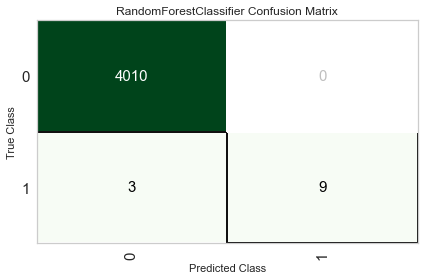

In [14]:
plot_model(best_model_with_oversampling, plot = 'confusion_matrix')

Theorie: Recall, Precision, f1

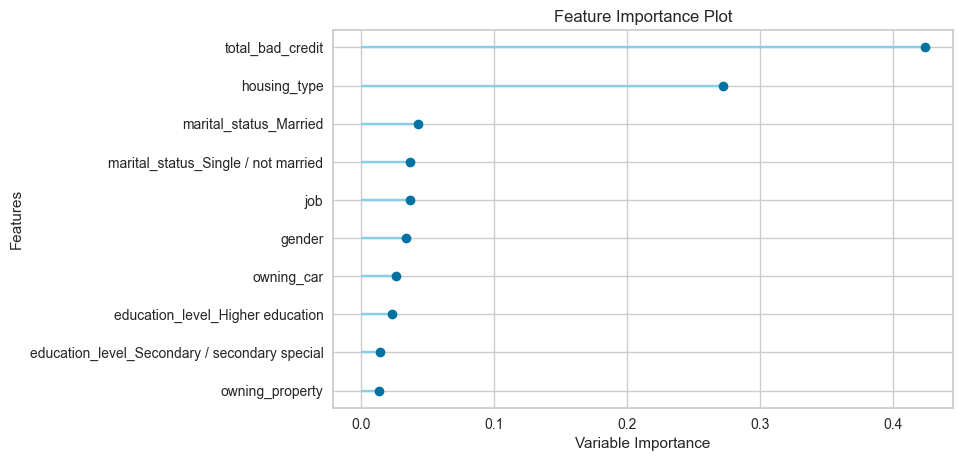

In [15]:
plot_model(best_model_with_oversampling, plot='feature')

In [21]:
#evaluate_model(best_model_with_oversampling)

## Downsampling mit Pycaret




thoerie: Undersampling Methode: Nearmiss

In [16]:
stp_downsampled = pycaret.classification.setup(data = training_data, target = 'risk_user', train_size = 0.8,
            categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level',
                                    'marital_status', 'housing_type', 
                                    'job'],  fold_strategy = 'kfold',
            fix_imbalance = True, fix_imbalance_method = imblearn.under_sampling.AllKNN() , fold = 10,
            ignore_features = ['applicant_ID'])

,Description,Value
0,Session id,5457
1,Target,risk_user
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(20107, 18)"
5,Transformed data shape,"(20064, 28)"
6,Transformed train set shape,"(16042, 28)"
7,Transformed test set shape,"(4022, 28)"
8,Ignore features,1
9,Ordinal features,3


In [17]:
best_model_with_downsampling = compare_models(exclude = 'dummy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9970,0.7233,0.0000,0.0000,0.0000,0.0000,0.0000,0.6140
svm,SVM - Linear Kernel,0.9970,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4850
ridge,Ridge Classifier,0.9970,0.0000,0.0583,0.2000,0.0900,0.0897,0.1074,0.4610
lr,Logistic Regression,0.9969,0.8358,0.1767,0.3433,0.2186,0.2177,0.2366,4.2210
rf,Random Forest Classifier,0.9969,0.9444,0.0000,0.0000,0.0000,-0.0001,-0.0001,0.7470
ada,Ada Boost Classifier,0.9969,0.9617,0.0125,0.1000,0.0222,0.0220,0.0351,0.7240
xgboost,Extreme Gradient Boosting,0.9969,0.9497,0.0216,0.1500,0.0376,0.0372,0.0562,1.0660
et,Extra Trees Classifier,0.9968,0.9425,0.1074,0.3667,0.1567,0.1558,0.1886,0.7800
lightgbm,Light Gradient Boosting Machine,0.9968,0.8233,0.0466,0.1167,0.0629,0.0622,0.0706,0.5380
gbc,Gradient Boosting Classifier,0.9967,0.8586,0.0616,0.1900,0.0767,0.0759,0.0944,1.1470


Processing:   0%|          | 0/45 [00:00<?, ?it/s]

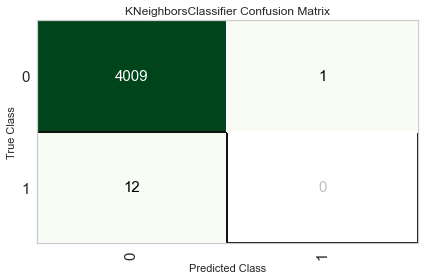

In [18]:
plot_model(best_model_with_downsampling, plot = 'confusion_matrix')

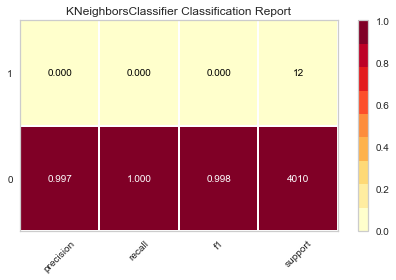

In [19]:
plot_model(best_model_with_downsampling, plot = 'class_report')

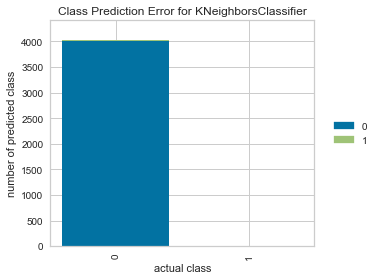

In [20]:
plot_model(best_model_with_downsampling, plot = 'error')

Theorie: Precision/recall Kurve

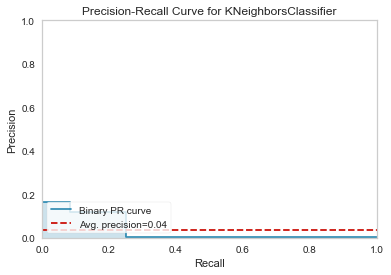

In [21]:
plot_model(best_model_with_downsampling, plot = 'pr')

theorie: Learning curve.

Notiz: generell sieht man hier, das das Model anfang erst underfittet bzw unfähig ist mit der Komplesitöt im Datensatz klarzukommen.

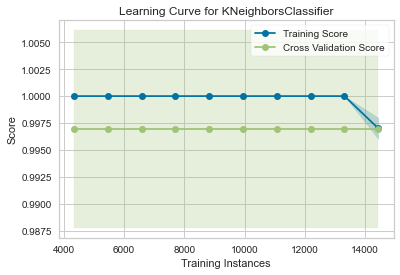

In [22]:
plot_model(best_model_with_downsampling, plot = 'learning')

## Anderer Ansatz

Es ist auffällig, wie die Accuracy von den vorgeschlagenen Modellen sowohl mithilfe von Oversampling als auch downsampling aus Pycaret so hoch ist. Die Vermutung ist, dass eine 100-prozentige Genauigkeit erreicht wurden ist, indem das Modell einfach alle Nullen in diesem speziellen Fall im Datensatz vorhergesagt haben. 



In [58]:
target = 'risk_user'
modeltype = 'Classification'

In [59]:
## First we will check for and remove ID variables
nunique_train=cca_for_test.nunique().reset_index()
idvars = nunique_train[(nunique_train[0]==len(cca_for_test)) | (nunique_train[0]==0) | (nunique_train[0]==1) ]['index'].tolist()
idvars

['applicant_ID']

In [60]:
if isinstance(target, str):
    preds = [x for x in list(cca_for_test) if x not in idvars+[target]]
else:
    preds = [x for x in list(cca_for_test) if x not in idvars+target]
len(preds)

17

In [61]:
from sklearn.model_selection import train_test_split
seed = 0
test_size = 0.15
X_train = cca_for_test[preds]
y_train = cca_for_test[target]
if modeltype =='Regression':
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed)
else:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed,shuffle=True, stratify=y)
    except:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed)
X_train.shape, X_test.shape


((21363, 17), (3771, 17))

Folgende Scritte sind:
- alle Objektvariablen in numerische umzmwandeln
- Ein hochgradig abgestimmtes Modell aufbauen, um Ungleichgewichte zu erkennen und entsprechend zu handeln.

Hier bei verwenden wir in diesem Projekt die Featurewiz unddie lazytransform-Bibliothek.

## Literaturverzeichnis

- [1] https://pestleanalysis.com/descriptive-analysis/#What_Is_Descriptive_Analysis
- [2] https://machinelearningmastery.com/what-is-imbalanced-classification/
- [3] https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html
